# Классификация изображений природы по времени года

**Проектная работа Ситникова Андрея на курсе «Machine Learning. Professional»**

## Часть 4. Классификация

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

np.random.seed(100)

Загружаем датафрейм, сформированный в прошлой части.

In [3]:
df = pd.read_csv('df_ml.csv')
df

,season,c000,c001,c002,c003,c004,c005,c010,c011,c012,...,c542,c543,c544,c545,c550,c551,c552,c553,c554,c555
0,summer,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,summer,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,summer,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,summer,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,summer,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2338,spring,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2339,spring,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2340,spring,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2341,spring,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


Делаем train-test разбиение.

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['season'], axis=1), df['season'], test_size=0.25, random_state=100, stratify=df['season']
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1757, 216), (1757,), (586, 216), (586,))

### KNN

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix

In [6]:
def quality(true_y, prediction_y):
    accuracy = accuracy_score(true_y, prediction_y)
    precision = precision_score(true_y, prediction_y, average='weighted')
    recall = recall_score(true_y, prediction_y, average='weighted')
    f1 = f1_score(true_y, prediction_y, average='weighted')
    print("Accuracy:  {:.3f}\nPrecision: {:.3f}\nRecall:    {:.3f}\nF1-score:  {:.3f}".format(
        accuracy, precision, recall, f1
    ))

In [7]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
quality(y_test, knn.predict(X_test))

Accuracy:  0.411
Precision: 0.385
Recall:    0.411
F1-score:  0.391


Результаты откровенно плохие. Приведём подробный отчёт по каждому значению целевой переменной и построим матрицу ошибок.

              precision    recall  f1-score   support

      autumn      0.406     0.548     0.466       146
      spring      0.379     0.356     0.367       149
      summer      0.232     0.128     0.165       149
      winter      0.533     0.627     0.576       142

    accuracy                          0.411       586
   macro avg      0.387     0.414     0.393       586
weighted avg      0.385     0.411     0.391       586



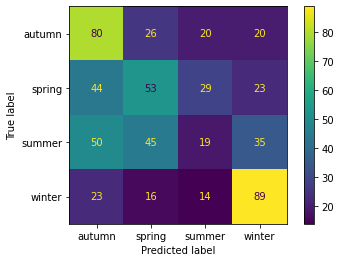

In [8]:
plot_confusion_matrix(knn, X_test, y_test)
print(classification_report(y_test, knn.predict(X_test), digits=3))

Видно, что относительно неплохо алгоритм угадывает картинки для осени и зимы. Это можно объяснить тем, что для тренировки использовались картинки, которые для осени и зимы действительно в массе отличаются цветовой гаммой, а для лета и весны картинки в принципе похожи.

Попробуем сделать кросс-валидацию метода ближайших соседей.

100%|██████████| 49/49 [01:31<00:00,  1.86s/it]


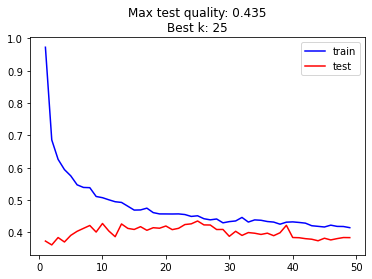

In [11]:
f1_score_train = []
f1_score_test = []
for k in tqdm(range(1, 50)):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    f1_score_train.append(f1_score(y_train, knn.predict(X_train), average='weighted'))
    f1_score_test.append(f1_score(y_test, knn.predict(X_test), average='weighted'))
    
plt.plot(neighbors, f1_score_train, color='blue', label='train')
plt.plot(neighbors, f1_score_test, color='red', label='test')
plt.title("Max test quality: {:.3f}\nBest k: {}".format(max(f1_score_test), np.argmax(f1_score_test)+1))
plt.legend();

При k = 25 F1-score возросла с 0.391 до 0.435, что тоже мало.

Возможно, другие алгоритмы классификации покажут себя лучше?

### Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
quality(y_test, log_reg.predict(X_test))

Accuracy:  0.471
Precision: 0.456
Recall:    0.471
F1-score:  0.460


Метрики немного лучше, чем для KNN. Сделаем кросс-валидацию.

In [13]:
from sklearn.linear_model import LogisticRegressionCV

log_reg_cv = LogisticRegressionCV(cv=5, scoring='f1_weighted', verbose=5, n_jobs=-1)
log_reg_cv.fit(X_train, y_train)

quality(log_reg_cv.predict(X_test), y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.7s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.4s finished


Accuracy:  0.490
Precision: 0.526
Recall:    0.490
F1-score:  0.503


F1-score на этом шаге наконец-то перевалил за 0.5.

              precision    recall  f1-score   support

      autumn      0.503     0.589     0.543       146
      spring      0.472     0.456     0.464       149
      summer      0.337     0.228     0.272       149
      winter      0.582     0.697     0.635       142

    accuracy                          0.490       586
   macro avg      0.474     0.493     0.478       586
weighted avg      0.472     0.490     0.476       586



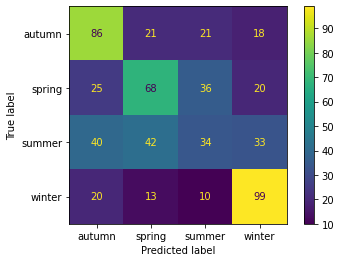

In [19]:
plot_confusion_matrix(log_reg_cv, X_test, y_test)
print(classification_report(y_test, log_reg_cv.predict(X_test), digits=3))

По-прежнему осень и зиму определяет лучше, лето хуже всех.

### CatBoost

In [15]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier()
cat.fit(X_train, y_train)
quality(y_test, cat.predict(X_test))

Learning rate set to 0.081434
0:	learn: 1.3687785	total: 226ms	remaining: 3m 46s
1:	learn: 1.3529031	total: 238ms	remaining: 1m 58s
2:	learn: 1.3424381	total: 249ms	remaining: 1m 22s
3:	learn: 1.3279515	total: 260ms	remaining: 1m 4s
4:	learn: 1.3185206	total: 270ms	remaining: 53.8s
5:	learn: 1.3071495	total: 281ms	remaining: 46.5s
6:	learn: 1.2951885	total: 291ms	remaining: 41.3s
7:	learn: 1.2838709	total: 302ms	remaining: 37.4s
8:	learn: 1.2775807	total: 312ms	remaining: 34.3s
9:	learn: 1.2678705	total: 322ms	remaining: 31.9s
10:	learn: 1.2590385	total: 333ms	remaining: 29.9s
11:	learn: 1.2519704	total: 343ms	remaining: 28.2s
12:	learn: 1.2465875	total: 353ms	remaining: 26.8s
13:	learn: 1.2407865	total: 365ms	remaining: 25.7s
14:	learn: 1.2331286	total: 376ms	remaining: 24.7s
15:	learn: 1.2257666	total: 387ms	remaining: 23.8s
16:	learn: 1.2192243	total: 397ms	remaining: 23s
17:	learn: 1.2133615	total: 407ms	remaining: 22.2s
18:	learn: 1.2086227	total: 418ms	remaining: 21.6s
19:	learn:

              precision    recall  f1-score   support

      autumn      0.443     0.507     0.473       146
      spring      0.386     0.342     0.363       149
      summer      0.275     0.262     0.268       149
      winter      0.600     0.613     0.606       142

    accuracy                          0.428       586
   macro avg      0.426     0.431     0.428       586
weighted avg      0.424     0.428     0.425       586



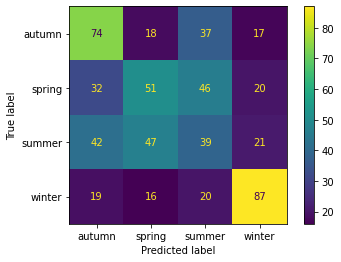

In [16]:
plot_confusion_matrix(cat, X_test, y_test)
print(classification_report(y_test, cat.predict(X_test), digits=3))

Метрики хуже, чем для логистической регрессии.

### SVM

In [17]:
from sklearn import svm

svc = svm.SVC()
svc.fit(X_train, y_train)
quality(y_test, svc.predict(X_test))

Accuracy:  0.473
Precision: 0.451
Recall:    0.473
F1-score:  0.454


              precision    recall  f1-score   support

      autumn      0.468     0.596     0.524       146
      spring      0.435     0.430     0.432       149
      summer      0.314     0.181     0.230       149
      winter      0.593     0.697     0.641       142

    accuracy                          0.473       586
   macro avg      0.452     0.476     0.457       586
weighted avg      0.451     0.473     0.454       586



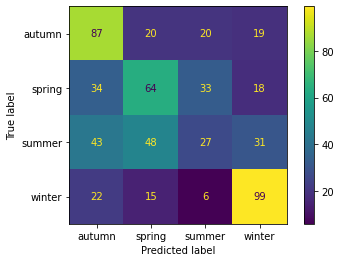

In [18]:
plot_confusion_matrix(svc, X_test, y_test)
print(classification_report(y_test, svc.predict(X_test), digits=3))

Здесь тоже метрики низкие.

**Вывод**: В классификации исходной задачи лучше всех показал себя алгоритм логистической регрессии с кросс-валидацией, но и его метрики далеко от удовлетворительных. 

**Гипотеза**: В следующей части попробуем проделать то же самое, упростив задачу: отделим картинки зимы от не-зимы, то есть сведём к бинарной классификации.